In [71]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random as rnd
print(os.listdir("../input"))

['mnist_train.csv', 'mnist_test.csv']


In [72]:
df = pd.read_csv('../input/mnist_test.csv', dtype="int32")
#y_df = pd.read_csv('../input/mnist_test.csv', header = None)
y = df['label']
x = df.drop('label', axis=1)

In [73]:
y = y.values
x = x.values

In [74]:
data_x = []
data_y = []
for index, label in enumerate(y):
    if(label == 3 or label == 8):
        data_x.append(x[index])
        if(label == 3):
          data_y.append(1)
        else:
          data_y.append(-1) 

In [75]:
data_x = np.asarray(data_x)
data_y = np.asarray(data_y)
print("shape of x: "+ str(data_x.shape), "shape of y: "+str(data_y.shape))

shape of x: (1984, 784) shape of y: (1984,)


In [76]:
X_train, X_test, Y_train, Y_test = tts(data_x, data_y, test_size = 0.4, random_state = 5)

In [77]:
class SVM():
    def __init__(self, max_iter=100, kernel_type='linear', C=1.0, epsilon=0.001):
        self.kernels = {
            'linear' : self.kernel_linear,
            'quadratic' : self.kernel_quadratic,
            'gaussian' : self.kernel_gauss
        }
        self.max_iter = max_iter
        self.kernel_type = kernel_type
        self.C = C
        self.epsilon = epsilon
    def fit(self, X, y):
        n, d = X.shape[0], X.shape[1]
        alpha = np.zeros((n))
        kernel = self.kernels[self.kernel_type]
        count = 0
        while True:
            count += 1
            alpha_prev = np.copy(alpha)
            for j in range(0, n):
                i = self.get_rnd_int(0, n-1, j) # Get random int i~=j
                x_i, x_j, y_i, y_j = X[i,:], X[j,:], y[i], y[j]
                k_ij = kernel(x_i, x_i) + kernel(x_j, x_j) - 2 * kernel(x_i, x_j)
                if k_ij == 0:
                    continue
                alpha_prime_j, alpha_prime_i = alpha[j], alpha[i]
                (L, H) = self.compute_L_H(self.C, alpha_prime_j, alpha_prime_i, y_j, y_i)

                # Compute model parameters
                self.w = self.calc_w(alpha, y, X)
                self.b = self.calc_b(X, y, self.w)

                # Compute E_i, E_j
                E_i = self.E(x_i, y_i, self.w, self.b)
                E_j = self.E(x_j, y_j, self.w, self.b)

                # Set new alpha values
                alpha[j] = alpha_prime_j + float(y_j * (E_i - E_j))/k_ij
                alpha[j] = max(alpha[j], L)
                alpha[j] = min(alpha[j], H)

                alpha[i] = alpha_prime_i + y_i*y_j * (alpha_prime_j - alpha[j])
#                 if(j % 100 == 0):
#                     print(j)
            # Check convergence
            diff = np.linalg.norm(alpha - alpha_prev)
            if diff < self.epsilon:
                break
            #print(count)
            if count >= self.max_iter:
                print("Iteration number exceeded the max of %d iterations" % (self.max_iter))
                return
        self.b = self.calc_b(X, y, self.w)
        if self.kernel_type == 'linear':
            self.w = self.calc_w(alpha, y, X)
        # Get support vectors
        alpha_idx = np.where(alpha > 0)[0]
        support_vectors = X[alpha_idx, :]
        return support_vectors, count
    def predict(self, X):
        return self.h(X, self.w, self.b)
    def calc_b(self, X, y, w):
        b_tmp = y - np.dot(w.T, X.T)
        return np.mean(b_tmp)
    def calc_w(self, alpha, y, X):
        return np.dot(X.T, np.multiply(alpha,y))
    def h(self, X, w, b):
        return np.sign(np.dot(w.T, X.T) + b).astype(int)
    def E(self, x_k, y_k, w, b):
        return self.h(x_k, w, b) - y_k
    def compute_L_H(self, C, alpha_prime_j, alpha_prime_i, y_j, y_i):
        if(y_i != y_j):
            return (max(0, alpha_prime_j - alpha_prime_i), min(C, C - alpha_prime_i + alpha_prime_j))
        else:
            return (max(0, alpha_prime_i + alpha_prime_j - C), min(C, alpha_prime_i + alpha_prime_j))
    def get_rnd_int(self, a,b,z):
        i = z
        cnt=0
        while i == z and cnt<1000:
            i = rnd.randint(a,b)
            cnt=cnt+1
        return i
    def kernel_linear(self, x1, x2):
        return np.dot(x1, x2.T)
    def kernel_quadratic(self, x1, x2):
        return (np.dot(x1, x2.T) ** 2)
    def kernel_gauss(self,x1, x2, sigma=1):
        return np.exp(- (np.linalg.norm(x1 - x2, 2)) ** 2 / (2 * sigma ** 2))
    def predict_proba(self, X):
        return np.dot(self.w.T, X.T) + self.b

In [78]:
model = SVM(max_iter=3, kernel_type='linear', C=3.0, epsilon=0.001)
model.fit(X_train, Y_train)
Y_predicted = [model.predict(x) for x in X_test]
cm = confusion_matrix(Y_test, Y_predicted)
accuracy = (cm[0][0] + cm[1][1]) / (cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1])
print(accuracy)

0.9496221662468514


In [79]:
model = SVM(max_iter=3, kernel_type='gaussian', C=1.0, epsilon=0.001)
model.fit(X_train, Y_train)
Y_predicted = [model.predict(x) for x in X_test]
cm = confusion_matrix(Y_test, Y_predicted)
accuracy = (cm[0][0] + cm[1][1]) / (cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1])
print(accuracy)

Iteration number exceeded the max of 3 iterations
0.9521410579345088


In [80]:
model = SVM(max_iter=3, kernel_type='quadratic', C=1.0, epsilon=0.001)
model.fit(X_train, Y_train)
Y_predicted = [model.predict(x) for x in X_test]
cm = confusion_matrix(Y_test, Y_predicted)
accuracy = (cm[0][0] + cm[1][1]) / (cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1])
print(accuracy)

0.46977329974811083


In [81]:
import sklearn.metrics as metrics

def ROC():
    fpr = []
    tpr = []
    for i in range(1,6):
        model = SVM(max_iter=3, kernel_type='linear', C=i, epsilon=0.001)
        model.fit(X_train, Y_train)
        Y_predicted = [model.predict(x) for x in X_test]
        cm = confusion_matrix(Y_test, Y_predicted)
        tn, fp, fn, tp = cm.ravel()
        fpr.append(fp)
        tpr.append(tp)
        model = None
        print("done")
    return fpr,tpr

# preds = probs[:,1]
# fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
# roc_auc = metrics.auc(fpr, tpr)




In [82]:
# method I: plt
import matplotlib.pyplot as plt
fpr, tpr = ROC()


done
done
done
done
done


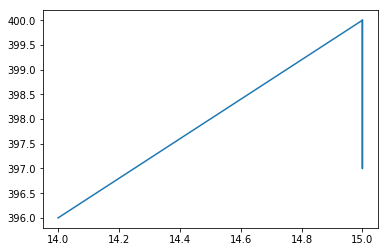

In [83]:
plt.plot(fpr,tpr)
plt.show() 

# This is the AUC
auc = np.trapz(tpr,fpr)

In [ ]:
auc

In [ ]:
fpr

In [ ]:
tpr